In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:1]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/labels/2129e57f-a27f-11ee-8249-e3998be94514.json
/kaggle/input/dataset/aug_data/val/labels/26984ab0-a27f-11ee-b5ae-e3998be94514.44.json
/kaggle/input/dataset/aug_data/val/images/1377166e-a283-11ee-9372-e3998be94514.3.jpg
/kaggle/input/dataset/aug_data/test/labels/2855b1c9-a27f-11ee-b04f-e3998be94514.35.json
/kaggle/input/dataset/aug_data/test/images/22810b02-a27f-11ee-bbc1-e3998be94514.9.jpg
/kaggle/input/dataset/aug_data/train/labels/2bb8659f-a27f-11ee-bff7-e3998be94514.24.json
/kaggle/input/dataset/aug_data/train/images/2fe63c5d-a27f-11ee-9265-e3998be94514.40.jpg
/kaggle/input/images/217f76e5-a27f-11ee-aaed-e3998be94514.jpg


In [38]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

In [39]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [40]:
tf.test.is_gpu_available()

False

In [41]:
input_size_w = 120
input_size_h = 120
CLASSES = 3


def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [42]:
train_images = tf.data.Dataset.list_files('/kaggle/input/dataset/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (input_size_w, input_size_h)))
train_images = train_images.map(lambda x: x / 255)

In [43]:
test_images = tf.data.Dataset.list_files('/kaggle/input/dataset/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (input_size_w,input_size_h)))
test_images = test_images.map(lambda x: x/255)

In [44]:
val_images = tf.data.Dataset.list_files('/kaggle/input/dataset/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (input_size_w,input_size_h)))
val_images = val_images.map(lambda x: x/255)

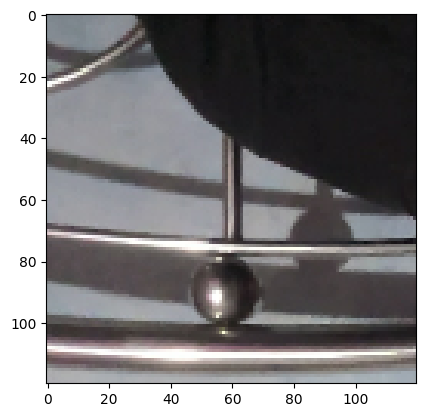

In [45]:
plt.imshow(train_images.as_numpy_iterator().next())

In [46]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [47]:
train_labels = tf.data.Dataset.list_files('/kaggle/input/dataset/aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [48]:
test_labels = tf.data.Dataset.list_files('/kaggle/input/dataset/aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))


In [49]:
val_labels = tf.data.Dataset.list_files('/kaggle/input/dataset/aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [50]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4860, 4860, 1320, 1320, 660, 660)

In [51]:
 val_labels

<_MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None))>

In [52]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [53]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [54]:
test

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), (TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None)))>

In [55]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [56]:
# train.as_numpy_iterator().next()[1]

In [57]:
# train.as_numpy_iterator().next()[0].shape

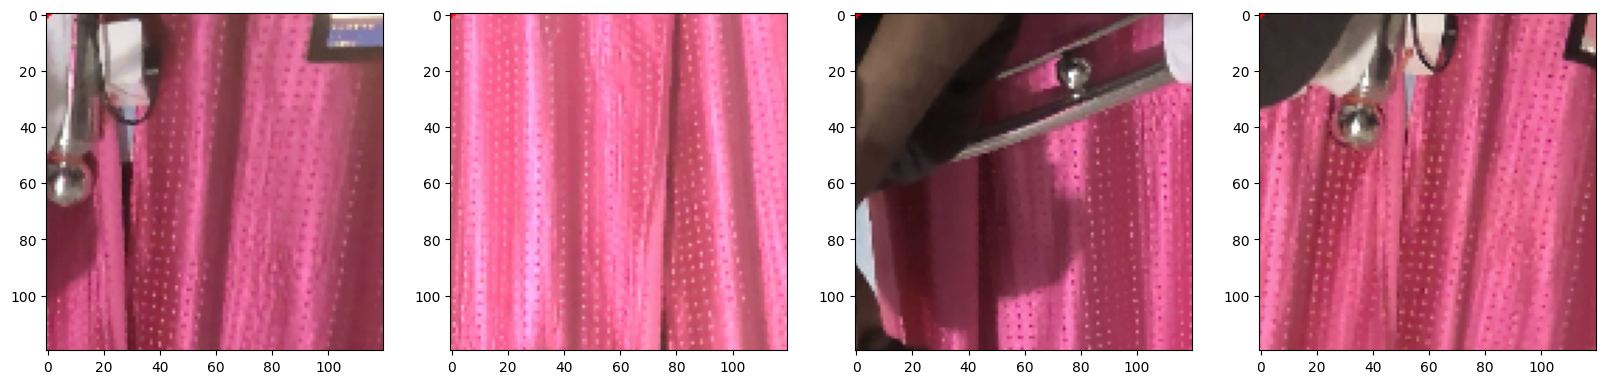

In [58]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [input_size_w,input_size_h]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [input_size_w,input_size_h]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [59]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [60]:
class Detector(Model): 
    def __init__(self, tracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = tracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs):     
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        classes, coords = self.model(X, training=False)
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)
    
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [61]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size_w, input_size_h, 3))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

def build_classifier_head(inputs):
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = '4', name = 'regressor_head')(inputs)

def build_model(inputs):
    
    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model


detector = build_model(tf.keras.layers.Input(shape=(input_size_w, input_size_h, 3)))

batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

model = Detector(detector)

model.compile(opt, classloss, regressloss)

In [62]:
hist = model.fit(train.take(30), epochs=20, validation_data=val)

Epoch 1/20
30/30 [==============================] - 12s 145ms/step - total_loss: 3.2305 - class_loss: 0.8974 - regress_loss: 2.7818 - val_total_loss: 0.8541 - val_class_loss: 0.5801 - val_regress_loss: 0.5641
Epoch 2/20
30/30 [==============================] - 11s 132ms/step - total_loss: 2.8220 - class_loss: 0.8968 - regress_loss: 2.3736 - val_total_loss: 0.9625 - val_class_loss: 0.4060 - val_regress_loss: 0.7595
Epoch 3/20
30/30 [==============================] - 11s 134ms/step - total_loss: 3.0725 - class_loss: 0.8564 - regress_loss: 2.6443 - val_total_loss: 1.4603 - val_class_loss: 0.9266 - val_regress_loss: 0.9970
Epoch 4/20
30/30 [==============================] - 11s 132ms/step - total_loss: 2.8912 - class_loss: 0.8716 - regress_loss: 2.4554 - val_total_loss: 2.4158 - val_class_loss: 1.2747 - val_regress_loss: 1.7785
Epoch 5/20
30/30 [==============================] - 10s 129ms/step - total_loss: 2.7055 - class_loss: 0.8394 - regress_loss: 2.2858 - val_total_loss: 1.7208 - val_c

In [70]:
import cv2
img = cv2.imread("/kaggle/input/images/11131b7f-a283-11ee-8442-e3998be94514.jpg")

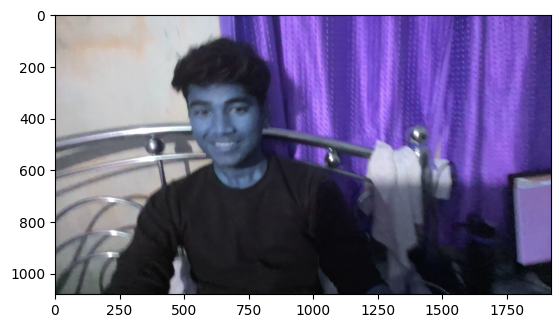

In [71]:
img = img/255
plt.imshow(img)

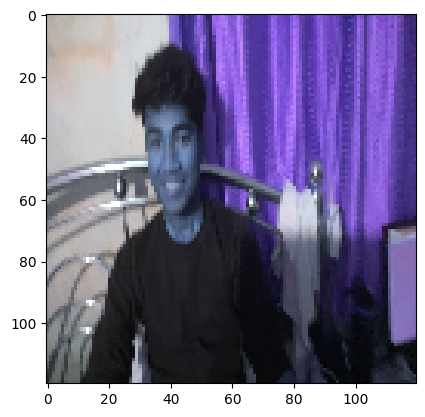

In [72]:
img = tf.image.resize(img,(120,120)).numpy()
# height, width = img.shape[:2]
# x_start, y_start = 0, 0
# x_end, y_end = min(width, 120), min(height, 120)
# img = img[y_start:y_end, x_start:x_end]
plt.imshow(img)

In [73]:
pred_img = np.expand_dims(img,axis=0)
y_pred = model.predict(pred_img)
y_pred

1/1 [==============================] - 0s 26ms/step


[array([[0.35246938, 0.32778636, 0.31974423]], dtype=float32),
 array([[ 0.20159966, -0.01587944,  0.4762027 ,  0.53805405]],
       dtype=float32)]

In [90]:
classes = ['Nothing','Face','Bottel']
idx = np.argmax(y_pred[0][0])
classes[idx]

'Nothing'

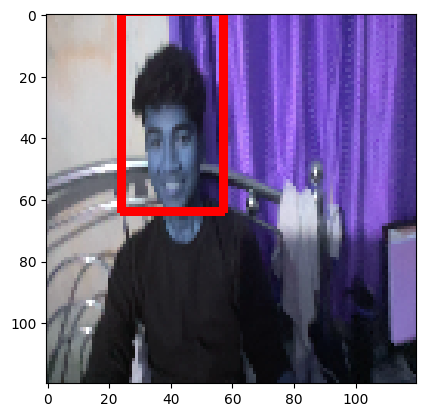

In [86]:
cv2.rectangle(img, 
              tuple(np.multiply(y_pred[1][0][:2], [input_size_w,input_size_h]).astype(int)),
              tuple(np.multiply(y_pred[1][0][2:], [input_size_w,input_size_h]).astype(int)), 
                    (255,0,0), 2)
plt.imshow(img)

In [79]:
from tensorflow.keras.models import save_model

# Assuming 'model' is your subclassed model
save_model(model, 'face-bottel-model', save_format='tf')

In [80]:
from tensorflow.keras.models import load_model
loaded_model = load_model('face-bottel-model')

In [85]:
y_pred = loaded_model.predict(pred_img)
y_pred

1/1 [==============================] - 0s 26ms/step


[array([[9.9226260e-01, 2.7825385e-05, 7.7095483e-03]], dtype=float32),
 array([[16.564959  , -0.63871044, 28.078806  , 21.866957  ]],
       dtype=float32)]

In [87]:
!zip -r model.zip /kaggle/working/face-bottel-model

  adding: kaggle/working/face-bottel-model/ (stored 0%)
  adding: kaggle/working/face-bottel-model/variables/ (stored 0%)
  adding: kaggle/working/face-bottel-model/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: kaggle/working/face-bottel-model/variables/variables.index (deflated 67%)
  adding: kaggle/working/face-bottel-model/fingerprint.pb (stored 0%)
  adding: kaggle/working/face-bottel-model/assets/ (stored 0%)
  adding: kaggle/working/face-bottel-model/keras_metadata.pb (deflated 92%)
  adding: kaggle/working/face-bottel-model/saved_model.pb (deflated 88%)
